In [1]:
import json

import geopandas as gpd
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Clustering
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes

# Preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Dimensionality reduction
from sklearn.decomposition import PCA

# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

# Feature importance visulization
import shap

### Load 4332-TX dataset

In [2]:
# Read from JSON
with open('../data/open-fema/FEMA-Large-DR-4332-TX.json','r') as f:
    femaData = json.loads(f.read())
femaDf_4332 = pd.json_normalize(femaData['fema_open_api'])

In [3]:
print('There are {} records in 4332-TX.'.format(len(femaDf_4332)))

There are 895512 records in 4332-TX.


### Load 4337-FL dataset

In [4]:
# Read from JSON
with open('../data/open-fema/FEMA-Large-DR-4337-FL.json','r') as f:
    femaData = json.loads(f.read())
femaDf_4337 = pd.json_normalize(femaData['fema_open_api'])

In [5]:
print('There are {} records in 4337-FL.'.format(len(femaDf_4337)))

There are 2643443 records in 4337-FL.


### Merge the 2 datasets

In [6]:
femaDf = pd.concat([femaDf_4332, femaDf_4337])

In [7]:
print('There are {} records combined.'.format(len(femaDf)))

There are 3538955 records combined.


In [8]:
femaDf.dtypes

disasterNumber                       int64
damagedCity                         object
damagedStateAbbreviation            object
damagedZipCode                      object
householdComposition                 int64
grossIncome                        float64
specialNeeds                          bool
ownRent                             object
residenceType                       object
homeOwnersInsurance                   bool
floodInsurance                        bool
inspected                             bool
rpfvl                              float64
habitabilityRepairsRequired         object
destroyed                             bool
waterLevel                         float64
floodDamage                           bool
foundationDamage                      bool
foundationDamageAmount              object
roofDamage                            bool
roofDamageAmount                    object
tsaEligible                           bool
tsaCheckedIn                          bool
rentalAssis

In [9]:
femaDf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
disasterNumber,3538955.0,4335.734779,2.173781,4332.00,4332.00,4337.0,4337.0000,4337.00
householdComposition,3538955.0,2.221524,1.497094,1.00,1.00,2.0,3.0000,99.00
grossIncome,2872567.0,65833.823389,574122.730297,0.00,15400.00,28400.0,50000.0000,99999999.00
rpfvl,429926.0,5083.210915,9035.879820,0.00,499.50,668.4,7156.1900,342300.76
waterLevel,1584092.0,2.472238,9.009927,0.00,0.00,0.0,0.0000,660.00
rentalAssistanceAmount,544659.0,1536.763187,1057.232735,22.80,1014.00,1295.0,1712.0000,32800.00
repairAmount,135318.0,7947.580856,7977.205409,3.72,1000.00,5660.0,12513.4825,33300.00
replacementAmount,781.0,25353.274277,6733.456105,1761.46,16232.46,29764.8,30501.9000,33300.00
ppfvl,1584092.0,443.587720,1402.170994,0.00,0.00,0.0,0.0000,191055.59


### Identify outliers/erroneous values

#### householdComposition - outliers

In [10]:
print('householdComposition has {} observation with value 99'.format((femaDf['householdComposition'] == 99).sum()))

householdComposition has 1 observation with value 99


#### grossIncome - outliers

In [11]:
print('grossIncome has {} observations with value 99999999.00'.format((femaDf['grossIncome'] == 99999999.00).sum()))

grossIncome has 3 observations with value 99999999.00


#### habitabilityRepairsRequired and primaryResidence - incorrect data type

In [12]:
# Convert dtype from object to boolean
femaDf['habitabilityRepairsRequired'] = femaDf['habitabilityRepairsRequired'].astype('bool')
femaDf['primaryResidence'] = femaDf['primaryResidence'].astype('bool')

#### waterLevel (inches) has few entries where waterLevel > 25 feet. 

In [16]:
print('waterLevel has {} observations with NA'.format((femaDf['waterLevel'].isna().sum())))

waterLevel has 1954863 observations with NA


In [13]:
print('waterLevel has {} observations with values > 300 inches (25 feet)'.format((femaDf['waterLevel'] > 300).sum()))

waterLevel has 10 observations with values > 300 inches (25 feet)


#### 'renterDamageLevel' mostly has na's, will probably exclude in modeling

In [14]:
print('renterDamageLevel has {:.2f}% missing values'.format((femaDf['renterDamageLevel'].isna().sum()/len(femaDf))*100))

renterDamageLevel has 97.45% missing values


### Aggregated haAmount column

In [15]:
# Define all the dollar amount columns
amount_cols = ['foundationDamageAmount', 'roofDamageAmount', 'rentalAssistanceAmount', 
               'replacementAmount','repairAmount', 'rpfvl', 'ppfvl']

# Set them to zero if null
femaDf[amount_cols] = femaDf[amount_cols].fillna(0)

# Calculate the aggregated haAmount
femaDf['haAmount'] = femaDf['rentalAssistanceAmount'] + femaDf['replacementAmount'] + femaDf['repairAmount']

print('Total ${:,.2f} in HA payouts'.format(femaDf['haAmount'].sum()))

Total $1,932,263,554.11 in HA payouts


#### How many observations have inspected=False, but haAmount > 0

### Extract a subset of columns for clustering

#### Note: Excluded residenceType (high cardinality) and residenceDamageLevel (ordinal)

In [11]:
# Extract a subset of columns
cols = ['householdComposition', 'specialNeeds', 'ownRent', 'homeOwnersInsurance', 'floodInsurance', 
        'inspected', 'rpfvl', 'habitabilityRepairsRequired', 'destroyed', 'waterLevel', 'floodDamage', 
        'foundationDamage', 'roofDamage', 'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible', 
        'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence']

In [ ]:
femaClusterDf = femaDf.loc[:, cols]

### Feature Scaling/Engineering

In [236]:
# Fill the na's with zero's in waterLevel for clustering 
femaClusterDf['waterLevel'].fillna(0, inplace=True)

# Let's remove the rows where waterLevel > 300 as clustering is sensitive to outliers
femaClusterDf = femaClusterDf[femaClusterDf.waterLevel < 300]

In [237]:
# Convert boolean columns to int
bool_cols = ['specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected', 'destroyed', 
             'habitabilityRepairsRequired', 'floodDamage', 'foundationDamage', 'roofDamage', 
             'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible', 
             'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence']

femaClusterDf[bool_cols] = femaClusterDf[bool_cols].astype(int)

In [238]:
# One-hot encode the categorical variables
cat_cols = ['ownRent']
for col in cat_cols:
    femaClusterDf = pd.concat([femaClusterDf, pd.get_dummies(femaClusterDf[col], prefix=col)], axis=1)
femaClusterDf.drop(cat_cols, axis=1, inplace=True)

In [239]:
# Scale the numeric columns using StandardScaler
num_cols = ['householdComposition', 'rpfvl', 'waterLevel']
femaClusterDf[num_cols] = pd.DataFrame(StandardScaler().fit_transform(femaClusterDf[num_cols]), columns=num_cols)

In [240]:
# Now scale the entire dataframe
femaClusterDf = pd.DataFrame(StandardScaler().fit_transform(femaClusterDf), columns=femaClusterDf.columns)

In [ ]:
# Sample a fraction
#femaClusterDf_small = femaClusterDf.sample(frac = 0.01)

### KMeans Clustering over the entire dataset

/Users/nitinserro/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

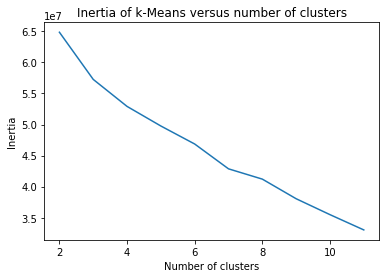

In [241]:
# Find the k for kmeans using elbow method
scores = [KMeans(n_clusters=i+2, init='k-means++').fit(femaClusterDf).inertia_ for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [242]:
# Fit K-means using best value for k from above
kmeans = KMeans(n_clusters=3, init='k-means++')
kmeans.fit(femaClusterDf)

KMeans(n_clusters=3)

In [243]:
# Perform PCA for visualization in 2-D
def perform_pca(n_components, df, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(df)
    pca_df = pd.DataFrame(matrix)
    pca_df.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    pca_df['labels'] = kmeans_labels
    
    return pca_df

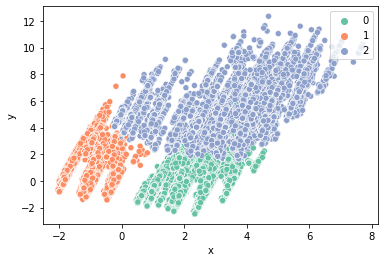

In [228]:
pca_df = perform_pca(3, femaClusterDf, kmeans.labels_)
sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, palette="Set2")
plt.legend(loc='upper right')

In [229]:
# Scale the columns for better visualization
df_scaled = pd.DataFrame(MinMaxScaler().fit_transform(femaClusterDf))
df_scaled.columns = femaClusterDf.columns

# Add the kmeans labels to the dataframe
df_scaled['kmeans'] = kmeans.labels_
femaClusterDf['kmeans'] = kmeans.labels_

In [230]:
# Look at the cluster distribution
femaClusterDf['kmeans'].value_counts()

1    1818668
0    1465442
2     254831
Name: kmeans, dtype: int64

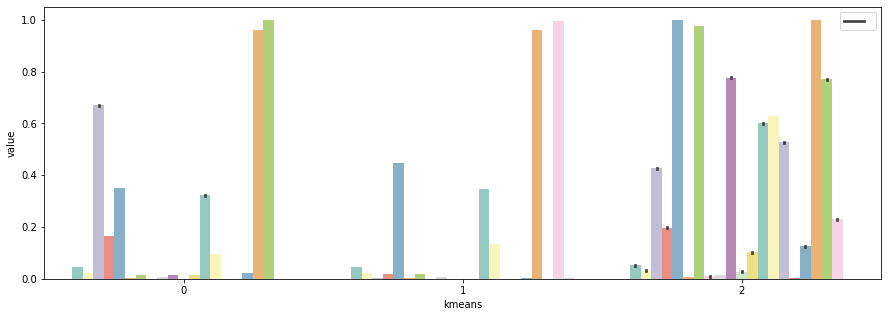

In [231]:
# Visualize the clusters, and variables
tidy = df_scaled.melt(id_vars='kmeans')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='kmeans', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend([''])

In [232]:
# Highlight the top features based on maximum variance across clusters
df_mean = femaClusterDf.groupby('kmeans').mean().reset_index()
results = pd.DataFrame(columns=['Variable', 'Std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('Std', ascending=False).head(7).Variable.values) + ['kmeans']

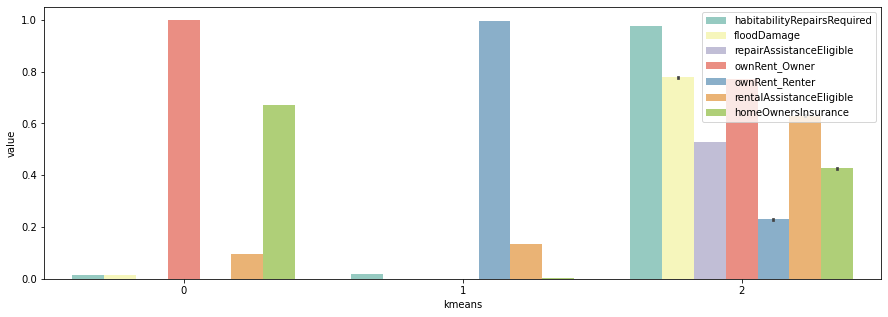

In [233]:
# Plot data
tidy = df_scaled[selected_columns].melt(id_vars='kmeans')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='kmeans', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper right')

### KMeans Clustering over boolean columns only

In [24]:
femaClusterDf_bool = femaDf.loc[:, bool_cols]

In [25]:
femaClusterDf_bool[bool_cols] = femaClusterDf_bool[bool_cols].astype(int)

In [26]:
femaClusterDf_bool.columns.tolist()

['specialNeeds',
 'homeOwnersInsurance',
 'floodInsurance',
 'inspected',
 'destroyed',
 'habitabilityRepairsRequired',
 'floodDamage',
 'foundationDamage',
 'roofDamage',
 'tsaEligible',
 'rentalAssistanceEligible',
 'repairAssistanceEligible',
 'replacementAssistanceEligible',
 'sbaEligible',
 'primaryResidence']

/Users/nitinserro/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

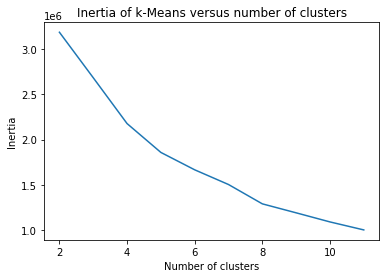

In [28]:
# Find the k for kmeans using elbow method
scores = [KMeans(n_clusters=i+2).fit(femaClusterDf_bool).inertia_ for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [29]:
# Fit K-means using best value for k from above
kmeans_bool = KMeans(n_clusters=3)
kmeans_bool.fit(femaClusterDf_bool)

KMeans(n_clusters=3)

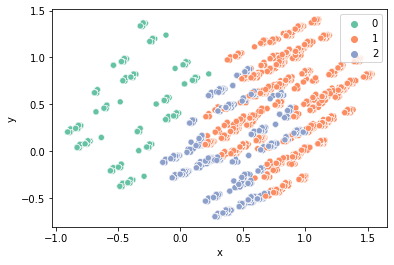

In [32]:
pca_df = perform_pca(3, femaClusterDf_bool, kmeans_bool.labels_)
sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, palette="Set2")
plt.legend(loc='upper right')

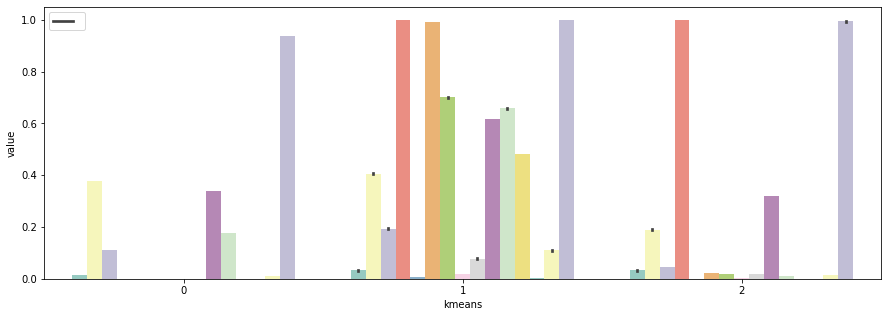

In [33]:
# Visualize the clusters, and variables
femaClusterDf_bool['kmeans'] = kmeans_bool.labels_
tidy = femaClusterDf_bool.melt(id_vars='kmeans')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='kmeans', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend([''])

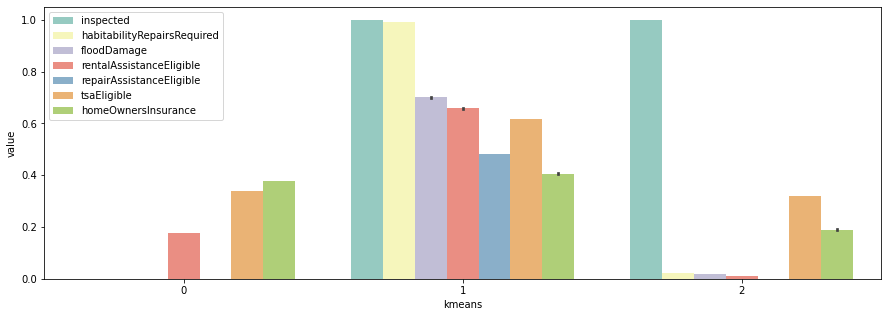

In [34]:
# Highlight the top features based on maximum variance across clusters
df_mean = femaClusterDf_bool.groupby('kmeans').mean().reset_index()
results = pd.DataFrame(columns=['Variable', 'Std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('Std', ascending=False).head(7).Variable.values) + ['kmeans']

# Plot data
tidy = femaClusterDf_bool[selected_columns].melt(id_vars='kmeans')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='kmeans', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper left')

### KPrototypes - Experimental

In [130]:
femaClusterDf_kproto = femaDf.sample(frac=0.01).loc[:, cols]

In [131]:
# Fill the na's with zero's in waterLevel for clustering 
femaClusterDf_kproto['waterLevel'].fillna(0, inplace=True)

# Let's remove the rows where waterLevel > 300 as clustering is sensitive to outliers
femaClusterDf_kproto = femaClusterDf_kproto[femaClusterDf_kproto.waterLevel < 300]

In [133]:
# Scale the numeric columns
num_cols = ['householdComposition', 'rpfvl', 'waterLevel']
femaClusterDf_kproto[num_cols] = femaClusterDf_kproto[num_cols].astype(float)
femaClusterDf_kproto[num_cols] = MinMaxScaler().fit_transform(femaClusterDf_kproto[num_cols])

In [134]:
# Convert the booleans to categorical
bool_cols = ['specialNeeds', 'homeOwnersInsurance', 'floodInsurance', 'inspected', 'destroyed', 
             'habitabilityRepairsRequired', 'floodDamage', 'foundationDamage', 'roofDamage', 
             'tsaEligible', 'rentalAssistanceEligible', 'repairAssistanceEligible', 
             'replacementAssistanceEligible', 'sbaEligible', 'primaryResidence']

femaClusterDf_kproto[bool_cols] = femaClusterDf_kproto[bool_cols].replace({True: 1, False: 0})
femaClusterDf_kproto[bool_cols] = femaClusterDf_kproto[bool_cols].astype(object)

In [135]:
# Convert categorical column into int-objects.
cat_cols = ['ownRent']

femaClusterDf_kproto[cat_cols] = femaClusterDf_kproto[cat_cols].replace({'Renter': 0, 'Owner': 1, 'Unknown': 2})
femaClusterDf_kproto[cat_cols] = femaClusterDf_kproto[cat_cols].astype(object)

In [136]:
femaClusterDf_kproto.dtypes

householdComposition             float64
specialNeeds                      object
ownRent                           object
homeOwnersInsurance               object
floodInsurance                    object
inspected                         object
rpfvl                            float64
habitabilityRepairsRequired       object
destroyed                         object
waterLevel                       float64
floodDamage                       object
foundationDamage                  object
roofDamage                        object
tsaEligible                       object
rentalAssistanceEligible          object
repairAssistanceEligible          object
replacementAssistanceEligible     object
sbaEligible                       object
primaryResidence                  object
dtype: object

In [139]:
kproto = KPrototypes(n_clusters=3).fit_predict(
    femaClusterDf_kproto, categorical=[1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18])

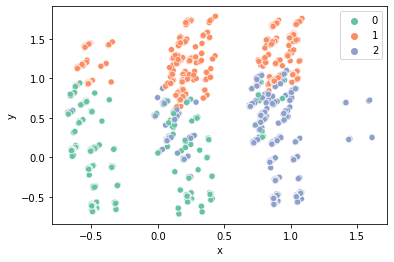

In [140]:
pca_df = perform_pca(3, femaClusterDf_kproto, kproto)
sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, palette="Set2")
plt.legend(loc='upper right')

In [141]:
femaClusterDf_kproto['kprototypes'] = kproto
femaClusterDf_kproto['kprototypes'].value_counts()

0    21642
2    11241
1     2507
Name: kprototypes, dtype: int64